In [1]:
import h5py
import shutil
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
def std_phi(phi):
    # return the phi in range [-pi, pi]
    while np.any(phi > np.pi):
        phi[phi > np.pi] -= 2 * np.pi
    while np.any(phi < -np.pi):
        phi[phi < -np.pi] += 2 * np.pi
    return phi

In [3]:
def get_dataset_keys(f):
    keys = []
    f.visit(lambda key : keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
    return keys

# $\eta - \phi$ smearing

In [4]:
def remove_inf(arr):
    return np.nan_to_num(arr, nan=0.0, posinf=0.0, neginf=0.0)

def pt_scale(pt):
    return np.sqrt(0.052*pt*pt + 1.502*pt)

def eta_phi_smearing(origin_file, output_path, n=3):

    with h5py.File(origin_file, 'r') as f:
        nevent = f['EVENT/signal'].shape[0]
        print(nevent)
        pt1, pt2 = f['J1/pt'][:], f['J2/pt'][:]
        eta1, eta2 = f['J1/eta'][:], f['J2/eta'][:]
        phi1, phi2 = f['J1/phi'][:], f['J2/phi'][:]

    shutil.copyfile(origin_file, 'tmp.h5')
    shutil.copyfile(origin_file, output_path)

    with h5py.File(output_path, 'a') as f_out:
        keys = get_dataset_keys(f_out)

        std_scale = 0.1

        total_size = nevent
        for i in tqdm(range(n)):
            total_size += nevent
            with h5py.File('tmp.h5', 'a') as f_tmp:

                f_tmp['J1/eta'][:] = remove_inf(np.random.normal(loc=eta1, scale=std_scale/pt1))
                f_tmp['J2/eta'][:] = remove_inf(np.random.normal(loc=eta2, scale=std_scale/pt2))
                f_tmp['J1/phi'][:] = std_phi(remove_inf(np.random.normal(loc=phi1, scale=std_scale/pt1)))
                f_tmp['J2/phi'][:] = std_phi(remove_inf(np.random.normal(loc=phi2, scale=std_scale/pt2)))

                # f_tmp['J1/pt'][:] = np.random.normal(loc=pt1, scale=pt_scale(pt1))
                # f_tmp['J2/pt'][:] = np.random.normal(loc=pt2, scale=pt_scale(pt2))
            
                for key in keys:
                    f_out[key].resize(total_size, axis=0)
                    f_out[key][-nevent:] = f_tmp[key]

In [5]:
origin_file = './HVmodel/data/DA/mix_sample.h5'
output_path = './HVmodel/data/DA/mix_sample_aug_3.h5'

eta_phi_smearing(origin_file, output_path, n=3)

48465


  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_2391909/4052669954.py:30: RuntimeWarning: divide by zero encountered in divide
  f_tmp['J1/eta'][:] = remove_inf(np.random.normal(loc=eta1, scale=std_scale/pt1))
/tmp/ipykernel_2391909/4052669954.py:31: RuntimeWarning: divide by zero encountered in divide
  f_tmp['J2/eta'][:] = remove_inf(np.random.normal(loc=eta2, scale=std_scale/pt2))
/tmp/ipykernel_2391909/4052669954.py:32: RuntimeWarning: divide by zero encountered in divide
  f_tmp['J1/phi'][:] = std_phi(remove_inf(np.random.normal(loc=phi1, scale=std_scale/pt1)))
/tmp/ipykernel_2391909/4052669954.py:33: RuntimeWarning: divide by zero encountered in divide
  f_tmp['J2/phi'][:] = std_phi(remove_inf(np.random.normal(loc=phi2, scale=std_scale/pt2)))
100%|██████████| 3/3 [00:13<00:00,  4.66s/it]


In [7]:
for i in range(11):

    origin_file = f'./HVmodel/data/DA/mix_sample_{i:.1f}.h5'
    output_path = f'./HVmodel/data/DA/mix_sample_{i:.1f}_aug_1.h5'

    eta_phi_smearing(origin_file, output_path, n=1)

48289


  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_2433416/1105156996.py:29: RuntimeWarning: divide by zero encountered in divide
  f_tmp['J1/eta'][:] = remove_inf(np.random.normal(loc=eta1, scale=std_scale/pt1))
/tmp/ipykernel_2433416/1105156996.py:30: RuntimeWarning: divide by zero encountered in divide
  f_tmp['J2/eta'][:] = remove_inf(np.random.normal(loc=eta2, scale=std_scale/pt2))
/tmp/ipykernel_2433416/1105156996.py:31: RuntimeWarning: divide by zero encountered in divide
  f_tmp['J1/phi'][:] = std_phi(remove_inf(np.random.normal(loc=phi1, scale=std_scale/pt1)))
/tmp/ipykernel_2433416/1105156996.py:32: RuntimeWarning: divide by zero encountered in divide
  f_tmp['J2/phi'][:] = std_phi(remove_inf(np.random.normal(loc=phi2, scale=std_scale/pt2)))
100%|██████████| 1/1 [00:04<00:00,  4.75s/it]


48465


100%|██████████| 1/1 [00:04<00:00,  4.71s/it]


48643


100%|██████████| 1/1 [00:04<00:00,  4.75s/it]


48819


100%|██████████| 1/1 [00:04<00:00,  4.73s/it]


48997


100%|██████████| 1/1 [00:04<00:00,  4.72s/it]


49174


100%|██████████| 1/1 [00:04<00:00,  4.78s/it]


49351


100%|██████████| 1/1 [00:04<00:00,  4.81s/it]


49528


100%|██████████| 1/1 [00:04<00:00,  4.76s/it]


49705


100%|██████████| 1/1 [00:04<00:00,  4.82s/it]


49883


100%|██████████| 1/1 [00:04<00:00,  4.83s/it]


50060


100%|██████████| 1/1 [00:04<00:00,  4.85s/it]


In [5]:
for i in range(11):

    origin_file = f'./HVmodel/data/DA/mix_sample_{i:.1f}.h5'
    output_path = f'./HVmodel/data/DA/mix_sample_{i:.1f}_aug_3.h5'

    eta_phi_smearing(origin_file, output_path, n=3)

48289


  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_2415367/1105156996.py:29: RuntimeWarning: divide by zero encountered in divide
  f_tmp['J1/eta'][:] = remove_inf(np.random.normal(loc=eta1, scale=std_scale/pt1))
/tmp/ipykernel_2415367/1105156996.py:30: RuntimeWarning: divide by zero encountered in divide
  f_tmp['J2/eta'][:] = remove_inf(np.random.normal(loc=eta2, scale=std_scale/pt2))
/tmp/ipykernel_2415367/1105156996.py:31: RuntimeWarning: divide by zero encountered in divide
  f_tmp['J1/phi'][:] = std_phi(remove_inf(np.random.normal(loc=phi1, scale=std_scale/pt1)))
/tmp/ipykernel_2415367/1105156996.py:32: RuntimeWarning: divide by zero encountered in divide
  f_tmp['J2/phi'][:] = std_phi(remove_inf(np.random.normal(loc=phi2, scale=std_scale/pt2)))
100%|██████████| 3/3 [00:13<00:00,  4.66s/it]


48465


100%|██████████| 3/3 [00:14<00:00,  4.71s/it]


48643


100%|██████████| 3/3 [00:14<00:00,  4.74s/it]


48819


100%|██████████| 3/3 [00:14<00:00,  4.71s/it]


48997


100%|██████████| 3/3 [00:14<00:00,  4.76s/it]


49174


100%|██████████| 3/3 [00:14<00:00,  4.73s/it]


49351


100%|██████████| 3/3 [00:14<00:00,  4.75s/it]


49528


100%|██████████| 3/3 [00:14<00:00,  4.77s/it]


49705


100%|██████████| 3/3 [00:14<00:00,  4.83s/it]


49883


100%|██████████| 3/3 [00:14<00:00,  4.90s/it]


50060


100%|██████████| 3/3 [00:14<00:00,  4.84s/it]


In [6]:
for i in range(11):

    origin_file = f'./HVmodel/data/DA/mix_sample_{i:.1f}.h5'
    output_path = f'./HVmodel/data/DA/mix_sample_{i:.1f}_aug_5.h5'

    eta_phi_smearing(origin_file, output_path, n=5)

48289


  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_2415367/1105156996.py:29: RuntimeWarning: divide by zero encountered in divide
  f_tmp['J1/eta'][:] = remove_inf(np.random.normal(loc=eta1, scale=std_scale/pt1))
/tmp/ipykernel_2415367/1105156996.py:30: RuntimeWarning: divide by zero encountered in divide
  f_tmp['J2/eta'][:] = remove_inf(np.random.normal(loc=eta2, scale=std_scale/pt2))
/tmp/ipykernel_2415367/1105156996.py:31: RuntimeWarning: divide by zero encountered in divide
  f_tmp['J1/phi'][:] = std_phi(remove_inf(np.random.normal(loc=phi1, scale=std_scale/pt1)))
/tmp/ipykernel_2415367/1105156996.py:32: RuntimeWarning: divide by zero encountered in divide
  f_tmp['J2/phi'][:] = std_phi(remove_inf(np.random.normal(loc=phi2, scale=std_scale/pt2)))
100%|██████████| 5/5 [00:23<00:00,  4.69s/it]


48465


100%|██████████| 5/5 [00:25<00:00,  5.14s/it]


48643


100%|██████████| 5/5 [00:25<00:00,  5.10s/it]


48819


100%|██████████| 5/5 [00:23<00:00,  4.79s/it]


48997


100%|██████████| 5/5 [00:25<00:00,  5.10s/it]


49174


100%|██████████| 5/5 [01:03<00:00, 12.67s/it]


49351


100%|██████████| 5/5 [02:19<00:00, 27.83s/it]


49528


100%|██████████| 5/5 [01:37<00:00, 19.43s/it]


49705


100%|██████████| 5/5 [01:00<00:00, 12.12s/it]


49883


100%|██████████| 5/5 [00:48<00:00,  9.61s/it]


50060


100%|██████████| 5/5 [00:24<00:00,  4.93s/it]


# Plot

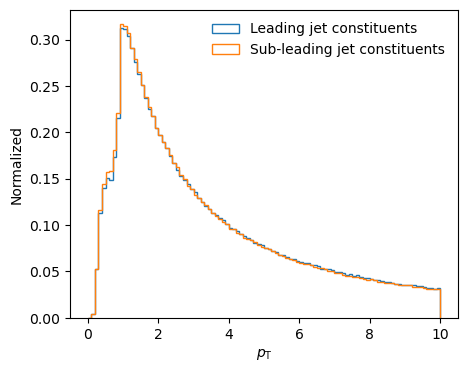

In [6]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

with h5py.File('./HVmodel/data/DA/mix_sample_1.0.h5', 'r') as f:
    M1, M2 = f['J1/MASK'][:], f['J2/MASK'][:]

    pt1 = np.concatenate([row[:M1[i].sum()] for i, row in enumerate(f['J1/pt'][:])])
    pt2 = np.concatenate([row[:M2[i].sum()] for i, row in enumerate(f['J2/pt'][:])])

ax.hist(pt1, bins=100, range=(0,10), histtype='step', label='Leading jet constituents', density=True)
ax.hist(pt2, bins=100, range=(0,10), histtype='step', label='Sub-leading jet constituents', density=True)


ax.legend()
ax.set_xlabel('$p_{\mathrm{T}}$')
ax.set_ylabel('Normalized')
ax.legend(frameon=False)

# plt.savefig('./figures/eta1_distribution_pt_smearing.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

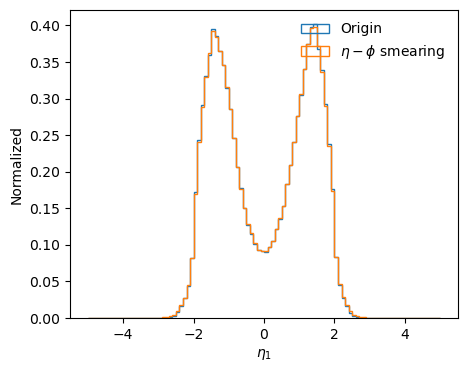

In [8]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

with h5py.File('./HVmodel/data/DA/mix_sample_1.0.h5', 'r') as f:
    M1, M2 = f['J1/MASK'][:], f['J2/MASK'][:]
    eta1 = np.concatenate([row[:M1[i].sum()] for i, row in enumerate(f['J1/eta'][:])])
ax.hist(eta1, bins=100, range=(-5, 5), histtype='step', label='Origin', density=True)

with h5py.File('./HVmodel/data/DA/mix_sample_1.0_aug_3.h5', 'r') as f:
    M1, M2 = f['J1/MASK'][:], f['J2/MASK'][:]
    eta1 = np.concatenate([row[:M1[i].sum()] for i, row in enumerate(f['J1/eta'][:])])
ax.hist(eta1, bins=100, range=(-5, 5), histtype='step', label='$\eta - \phi$ smearing', density=True)

ax.legend()
ax.set_xlabel('$\eta_1$')
ax.set_ylabel('Normalized')
ax.legend(frameon=False)

# plt.savefig('./figures/eta1_distribution_pt_smearing.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()